In [1]:
# Set the file path to the dataset
file_path = r'KDD+.txt'

# Define the column names corresponding to the NSL-KDD dataset
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level'
]

In [3]:

# Read the combined NSL-KDD dataset into a DataFrame
df = pd.read_csv(file_path, names=columns)


In [16]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0,0


## Preprocessing the Dataset


This section prepares the NSL-KDD dataset to train a random forest anomaly detection model. The primary goal is to transform the raw network traffic data into a usable format by creating classification targets, encoding categorical variables, and selecting important numeric features. We will produce both binary and multi-class targets, ensure that categorical data is machine-readable, and retain numeric metrics critical to the detection of abnormal traffic patterns.



### Creating a Binary Classification Target
The binary classification target identifies whether network traffic is normal or anomalous. We create a new column attack_flag in the DataFrame df to achieve this. Each row receives a label of 0 if the traffic is normal and 1 if it is an attack. This transformation simplifies the initial detection problem into a basic normal-versus-attack classification, which can be a starting point for a more granular analysis.



In [5]:
# Binary classification target
# Maps normal traffic to 0 and any type of attack to 1
df['attack_flag'] = df['attack'].apply(lambda a: 0 if a == 'normal' else 1)


### Creating the Multi-Class Classification Target
While a binary target is useful, it lacks granularity. To address this, we also create a multi-class classification target that distinguishes between different categories of attacks. We define lists categorizing specific attacks into four major groups:

DoS (Denial of Service) attacks such as neptune and smurf
Probe attacks that scan networks for vulnerabilities, like satan or ipsweep
Privilege Escalation attacks that attempt to gain unauthorized admin-level control, such as buffer_overflow
Access attacks that seek to breach system access controls, like guess_passwd
A custom function map_attack checks the type of attack and assigns it an integer:

- 0 for normal traffic
- 1 for DoS attacks
- 2 for Probe attacks
- 3 for Privilege Escalation attacks
- 4 for Access attacks


In [8]:
# Multi-class classification target categories
dos_attacks = ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 
               'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
probe_attacks = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
privilege_attacks = ['buffer_overflow', 'loadmdoule', 'perl', 'ps', 
                     'rootkit', 'sqlattack', 'xterm']
access_attacks = ['ftp_write', 'guess_passwd', 'http_tunnel', 'imap', 
                  'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack', 
                  'snmpguess', 'spy', 'warezclient', 'warezmaster', 
                  'xclock', 'xsnoop']

def map_attack(attack):
    if attack in dos_attacks:
        return 1
    elif attack in probe_attacks:
        return 2
    elif attack in privilege_attacks:
        return 3
    elif attack in access_attacks:
        return 4
    else:
        return 0
# Assign multi-class category to each row
df['attack_map'] = df['attack'].apply(map_attack)


In [10]:
# Encoding categorical variables
features_to_encode = ['protocol_type', 'service']
encoded = pd.get_dummies(df[features_to_encode])


In [11]:
encoded

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
148513,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
148514,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
148515,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
# Numeric features that capture various statistical properties of the traffic
numeric_features = [
    'duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 
    'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted', 
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 
    'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
    'dst_host_srv_rerror_rate'
]


In [13]:
# Combine encoded categorical variables and numeric features
train_set = encoded.join(df[numeric_features])

# Multi-class target variable
multi_y = df['attack_map']


In [14]:
train_set

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,False,True,False,False,False,False,False,False,False,False,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,False,False,True,False,False,False,False,False,False,False,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,False,True,False,False,False,False,False,False,False,False,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,False,True,False,False,False,False,False,False,False,False,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,False,True,False,False,False,False,False,False,False,False,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,False,True,False,False,False,False,False,False,False,False,...,100,141,0.72,0.06,0.01,0.01,0.01,0.00,0.00,0.00
148513,False,True,False,False,False,False,False,False,False,False,...,197,255,1.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00
148514,False,True,False,False,False,False,False,False,False,False,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.07,0.07
148515,False,False,True,False,False,False,False,False,False,False,...,255,252,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00


In [18]:
# Split data into training and test sets for multi-class classification
train_X, test_X, train_y, test_y = train_test_split(train_set, multi_y, test_size=0.2, random_state=1337)


In [19]:
# Further split the training set into separate training and validation sets
multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(train_X, train_y, test_size=0.3, random_state=1337)


## Training the Model


In [20]:
# Train RandomForest model for multi-class classification
rf_model_multi = RandomForestClassifier(random_state=1337)
rf_model_multi.fit(multi_train_X, multi_train_y)


RandomForestClassifier(random_state=1337)

Validation Set Evaluation:
Accuracy: 0.9950
Precision: 0.9949
Recall: 0.9950
F1-Score: 0.9949


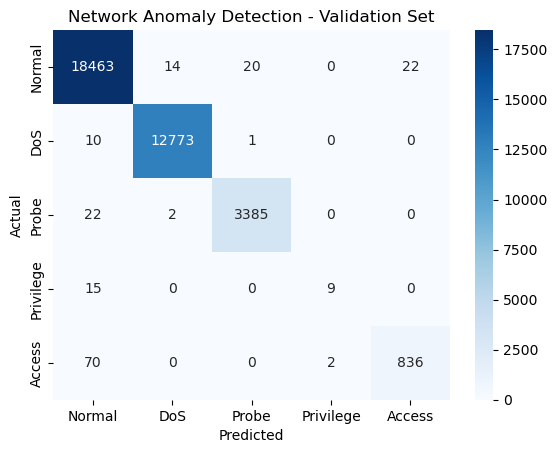

Classification Report for Validation Set:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00     18519
         DoS       1.00      1.00      1.00     12784
       Probe       0.99      0.99      0.99      3409
   Privilege       0.82      0.38      0.51        24
      Access       0.97      0.92      0.95       908

    accuracy                           1.00     35644
   macro avg       0.96      0.86      0.89     35644
weighted avg       0.99      1.00      0.99     35644



In [21]:
# Predict and evaluate the model on the validation set
multi_predictions = rf_model_multi.predict(multi_val_X)
accuracy = accuracy_score(multi_val_y, multi_predictions)
precision = precision_score(multi_val_y, multi_predictions, average='weighted')
recall = recall_score(multi_val_y, multi_predictions, average='weighted')
f1 = f1_score(multi_val_y, multi_predictions, average='weighted')
print(f"Validation Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix for Validation Set
conf_matrix = confusion_matrix(multi_val_y, multi_predictions)
class_labels = ['Normal', 'DoS', 'Probe', 'Privilege', 'Access']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Network Anomaly Detection - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report for Validation Set
print("Classification Report for Validation Set:")
print(classification_report(multi_val_y, multi_predictions, target_names=class_labels))


Test Set Evaluation:
Accuracy: 0.9949
Precision: 0.9947
Recall: 0.9949
F1-Score: 0.9947


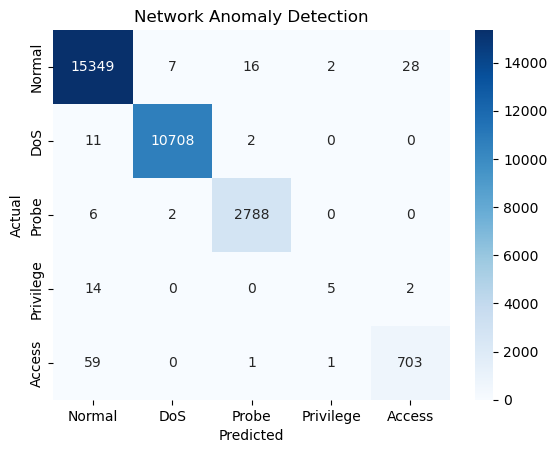

Classification Report for Test Set:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00     15402
         DoS       1.00      1.00      1.00     10721
       Probe       0.99      1.00      1.00      2796
   Privilege       0.62      0.24      0.34        21
      Access       0.96      0.92      0.94       764

    accuracy                           0.99     29704
   macro avg       0.91      0.83      0.85     29704
weighted avg       0.99      0.99      0.99     29704



In [22]:
# Final evaluation on the test set
test_multi_predictions = rf_model_multi.predict(test_X)
test_accuracy = accuracy_score(test_y, test_multi_predictions)
test_precision = precision_score(test_y, test_multi_predictions, average='weighted')
test_recall = recall_score(test_y, test_multi_predictions, average='weighted')
test_f1 = f1_score(test_y, test_multi_predictions, average='weighted')
print("\nTest Set Evaluation:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Confusion Matrix for Test Set
test_conf_matrix = confusion_matrix(test_y, test_multi_predictions)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Network Anomaly Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report for Test Set
print("Classification Report for Test Set:")
print(classification_report(test_y, test_multi_predictions, target_names=class_labels))


In [24]:
import joblib

# Save the trained model to a file
model_filename = 'network_anomaly_detection_model.joblib'
joblib.dump(rf_model_multi, model_filename)

print(f"Model saved to {model_filename}")

Model saved to network_anomaly_detection_model.joblib


In [25]:
import requests
import json

# Define the URL of the API endpoint
url = "http://localhost:8001/api/upload"

# Path to the model file you want to upload
model_file_path = "network_anomaly_detection_model.joblib"

# Open the file in binary mode and send the POST request
with open(model_file_path, "rb") as model_file:
    files = {"model": model_file}
    response = requests.post(url, files=files)

# Pretty print the response from the server
print(json.dumps(response.json(), indent=4))


{
    "accuracy": 0.9976096891754269,
    "flag": "HTB{n3tw0rk_tr4ff1c_4n0m4ly_d3t3ct0r}"
}
